<a href="https://colab.research.google.com/github/Kaif10/Pneumonia-Diagnosis/blob/master/Pneumonia_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I came across a challenging dataset on Kaggle of Pneumonia detection. The reason it is challenging is because of its abnormal distribution of train/val/test data. So Let's start.
I am using  Kaggle API.

I have tried three models here. Two of tranfer learning and one I applied my own CNN architecture.

In [0]:
from google.colab import files
!pip install -q kaggle



In [0]:
upload = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

Download the dataset into colab from kaggle

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 13.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.1MB/s]


Specify the path

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/tmp/chest-xray-pneumonia.zip

import os
import zipfile

local_zip = 'chest-xray-pneumonia.zip'

--2020-05-28 14:30:26--  https://storage.googleapis.com/tmp/chest-xray-pneumonia.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-05-28 14:30:26 ERROR 403: Forbidden.



Extracting the files

In [0]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/chest-xray-pneumonia')

Labeling the directories

In [0]:
zip_ref.close()
# Directory with our training pneumonia pictures
train_PNEUMONIA_dir = os.path.join('/tmp/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')

# Directory with our training normal pictures
train_NORMAL_dir = os.path.join('/tmp/chest-xray-pneumonia/chest_xray/train/NORMAL')

# Directory with our val pneumonia pictures
validation_PNEUMONIA_dir = os.path.join('/tmp/chest-xray-pneumonia/chest_xray/val/PNEUMONIA')

# Directory with our val normal pictures
validation_NORMAL_dir = os.path.join('/tmp/chest-xray-pneumonia/chest_xray/val/NORMAL')

# Directory with our test  pneumonia pictures
test_PNEUMONIA_dir = os.path.join('/tmp/chest-xray-pneumonia/chest_xray/test/PNEUMONIA')

# Directory with our test  normal pictures
test_NORMAL_dir = os.path.join('/tmp/chest-xray-pneumonia/chest_xray/test/NORMAL')

Lets take a look at the labels of some of our images

In [0]:
train_Pneumonia_fnames = os.listdir( train_PNEUMONIA_dir)
train_Normal_fnames = os.listdir( train_NORMAL_dir )
validation_Pneumonia_fnames = os.listdir( validation_PNEUMONIA_dir)
validation_Normal_fnames = os.listdir( validation_NORMAL_dir )
test_Pneumonia_fnames = os.listdir( test_PNEUMONIA_dir)
test_Normal_fnames = os.listdir( test_NORMAL_dir )
print(train_Pneumonia_fnames[:10])
print(train_Normal_fnames[:10])

['person1069_bacteria_3003.jpeg', 'person1628_bacteria_4293.jpeg', 'person1312_bacteria_3319.jpeg', 'person1008_virus_1691.jpeg', 'person1112_bacteria_3053.jpeg', 'person376_virus_759.jpeg', 'person810_virus_1446.jpeg', 'person1198_bacteria_3148.jpeg', 'person968_bacteria_2893.jpeg', 'person106_virus_194.jpeg']
['NORMAL2-IM-1269-0001-0001.jpeg', 'NORMAL2-IM-0941-0001.jpeg', 'IM-0588-0001.jpeg', 'NORMAL2-IM-1221-0001.jpeg', 'NORMAL2-IM-0930-0001.jpeg', 'NORMAL2-IM-0626-0001.jpeg', 'IM-0243-0001.jpeg', 'NORMAL2-IM-0881-0001.jpeg', 'NORMAL2-IM-1357-0001.jpeg', 'IM-0409-0001.jpeg']


Length of train/val/test data.

In [0]:
#len of train data
print(len(train_Pneumonia_fnames)+len(train_Normal_fnames))
#len of val data
print(len(validation_Pneumonia_fnames)+len(validation_Normal_fnames))
#len of train data
len(test_Pneumonia_fnames)+len(test_Normal_fnames)

5216
16


624

Plot some images from our data

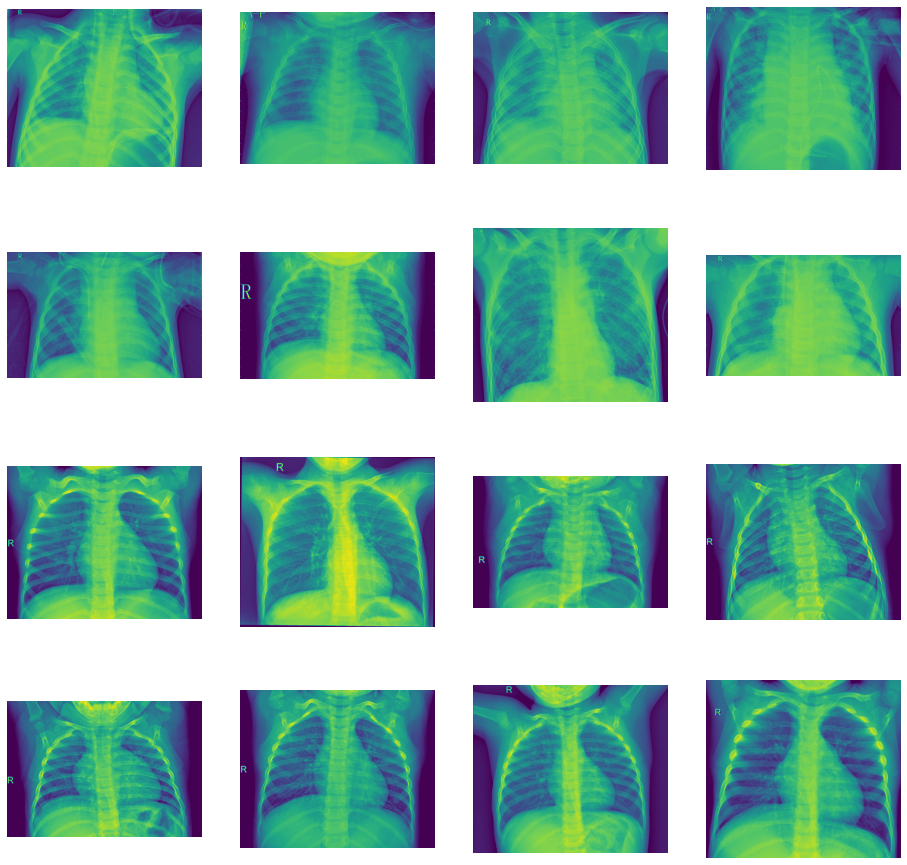

In [0]:
# Set up matplotlib fig, and size it to fit 4x4 pics
%matplotlib inline
labels = ['PNEUMONIA', 'NORMAL']
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_Pneumonia_pix = [os.path.join(train_PNEUMONIA_dir, fname) 
                for fname in train_Pneumonia_fnames[ pic_index-8:pic_index] 
               ]

next_Normal_pix = [os.path.join(train_NORMAL_dir, fname) 
                for fname in train_Normal_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_Pneumonia_pix+next_Normal_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  
plt.show()

In [0]:
#Here i will use the keras API on tensorflow
import tensorflow as tf
from tensorflow import keras

Data-Augmentation to provide over-fitting

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255., rotation_range=5,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest') 
val_datagen  = ImageDataGenerator( rescale = 1.0/255. )
classes = ["NORMAL", "PNEUMONIA"]
# --------------------
# Flow training images in batches of 32 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory('/tmp/chest-xray-pneumonia/chest_xray/train/',
                                                    batch_size=100,
                                                    shuffle = True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  val_datagen.flow_from_directory('/tmp/chest-xray-pneumonia/chest_xray/val/',
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150),
                                                         batch_size=1)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


First Model consists of VGG16 model transfer learning but in this i have trained the base layers also.
In Second Model, I have also used VGG16 but i have not trained the base layers and only trained  the new fully connected layers which I have added

In [0]:
#Since the data is small transfer learning is the best option
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,)  # Do not include the ImageNet classifier at the top.

Here comes our main pipeline. 

model

In [0]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation ='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation ='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(base_model.input, outputs)

In [0]:
#Summary
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

print_layers(model)

layer 0: input_5, trainable: True
layer 1: block1_conv1, trainable: True
layer 2: block1_conv2, trainable: True
layer 3: block1_pool, trainable: True
layer 4: block2_conv1, trainable: True
layer 5: block2_conv2, trainable: True
layer 6: block2_pool, trainable: True
layer 7: block3_conv1, trainable: True
layer 8: block3_conv2, trainable: True
layer 9: block3_conv3, trainable: True
layer 10: block3_pool, trainable: True
layer 11: block4_conv1, trainable: True
layer 12: block4_conv2, trainable: True
layer 13: block4_conv3, trainable: True
layer 14: block4_pool, trainable: True
layer 15: block5_conv1, trainable: True
layer 16: block5_conv2, trainable: True
layer 17: block5_conv3, trainable: True
layer 18: block5_pool, trainable: True
layer 19: flatten_7, trainable: True
layer 20: dense_17, trainable: True
layer 21: dropout_13, trainable: True
layer 22: dense_18, trainable: True
layer 23: dropout_14, trainable: True
layer 24: dense_19, trainable: True


Compile

In [0]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

Implementing Callbacks.

In [0]:
from keras.callbacks import  TensorBoard

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

In [0]:
hist = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    steps_per_epoch=20,
                    callbacks=[tensorboard],
                    verbose=2)

Epoch 1/20
20/20 - 41s - loss: 0.2737 - accuracy: 0.8870 - val_loss: 0.2298 - val_accuracy: 0.8750
Epoch 2/20
20/20 - 39s - loss: 0.1014 - accuracy: 0.9661 - val_loss: 1.1424 - val_accuracy: 0.7500
Epoch 3/20
20/20 - 41s - loss: 0.1123 - accuracy: 0.9605 - val_loss: 0.5817 - val_accuracy: 0.8125
Epoch 4/20
20/20 - 40s - loss: 0.1032 - accuracy: 0.9656 - val_loss: 0.1267 - val_accuracy: 0.9375
Epoch 5/20
20/20 - 41s - loss: 0.1440 - accuracy: 0.9520 - val_loss: 0.4522 - val_accuracy: 0.8125
Epoch 6/20
20/20 - 40s - loss: 0.0824 - accuracy: 0.9739 - val_loss: 0.9953 - val_accuracy: 0.7500
Epoch 7/20
20/20 - 41s - loss: 0.0910 - accuracy: 0.9685 - val_loss: 0.1818 - val_accuracy: 0.8750
Epoch 8/20
20/20 - 40s - loss: 0.0773 - accuracy: 0.9734 - val_loss: 0.4403 - val_accuracy: 0.8125
Epoch 9/20
20/20 - 40s - loss: 0.0744 - accuracy: 0.9729 - val_loss: 0.2071 - val_accuracy: 0.8750
Epoch 10/20
20/20 - 41s - loss: 0.1209 - accuracy: 0.9500 - val_loss: 0.5031 - val_accuracy: 0.8125
Epoch 11/

Now if you see the graph the training accuracy and loss are increasing and decreasing respectively which is  a good sign. But the validation plot has a lot of spikes, which is generally not a good sign. But as i said earlier the val data is very small only 16 images so the abnormal plot of spikes for validation data can be justified.

Text(0.5, 1.0, 'Training and validation loss')

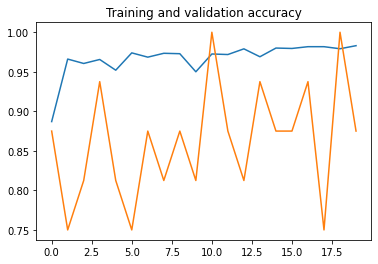

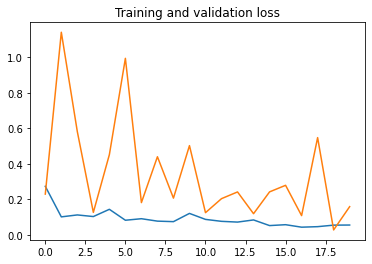

In [0]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = hist.history[ 'accuracy' ]
val_acc  = hist.history['val_accuracy']
loss     = hist.history[ 'loss']
val_loss = hist.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,  loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

.

model_two

In model_two I won't train the base layers of VGG16 and i will train only the new added layers.

In [0]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation ='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation ='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)
model_two = keras.Model(base_model.input, outputs)

In [0]:
model_two.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

training the new added layers.

In [0]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
      if layer not in base_model.layers:
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

print_layers(model_two)

layer 19: flatten_3, trainable: True
layer 20: dense_6, trainable: True
layer 21: dropout_4, trainable: True
layer 22: dense_7, trainable: True
layer 23: dropout_5, trainable: True
layer 24: dense_8, trainable: True


In [0]:
from tensorflow.keras.optimizers import Adam
model_two.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [0]:
history_two = model_two.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    steps_per_epoch=20,
                    verbose=2)

Epoch 1/20
20/20 - 42s - loss: 0.1737 - accuracy: 0.9180 - val_loss: 2.2009 - val_accuracy: 0.6875
Epoch 2/20
20/20 - 41s - loss: 0.1034 - accuracy: 0.9687 - val_loss: 0.4138 - val_accuracy: 0.8750
Epoch 3/20
20/20 - 43s - loss: 0.1217 - accuracy: 0.9603 - val_loss: 0.0682 - val_accuracy: 1.0000
Epoch 4/20
20/20 - 41s - loss: 0.0797 - accuracy: 0.9723 - val_loss: 0.2272 - val_accuracy: 0.8750
Epoch 5/20
20/20 - 40s - loss: 0.0699 - accuracy: 0.9791 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 6/20
20/20 - 41s - loss: 0.0843 - accuracy: 0.9675 - val_loss: 0.8170 - val_accuracy: 0.7500
Epoch 7/20
20/20 - 41s - loss: 0.0723 - accuracy: 0.9730 - val_loss: 0.3457 - val_accuracy: 0.8750
Epoch 8/20
20/20 - 40s - loss: 0.0540 - accuracy: 0.9807 - val_loss: 0.1905 - val_accuracy: 0.8750
Epoch 9/20
20/20 - 41s - loss: 0.0823 - accuracy: 0.9725 - val_loss: 0.8079 - val_accuracy: 0.6875
Epoch 10/20
20/20 - 40s - loss: 0.0651 - accuracy: 0.9807 - val_loss: 0.4142 - val_accuracy: 0.8125
Epoch 11/

As earlier said, the spikes in val data can be understood because of its small size.

Text(0.5, 1.0, 'Training and validation loss')

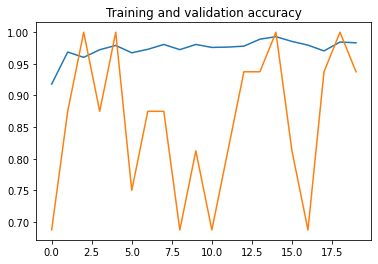

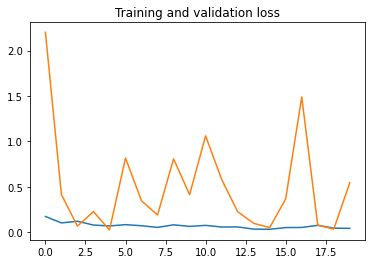

In [0]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs  = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,  loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

.


model_three

Here comes the challenging part. Implementing our own architecture without taking help from transfer learning on such a small dataset.

Getting a good accuracy will be very tough

In [0]:
model_three = keras.Sequential(
    [
        keras.Input(shape=(150,150,3)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same',activation="relu"),
        keras.layers.Conv2D(128, kernel_size=(3, 3),  activation="relu"),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
     
        keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu"),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
     
        keras.layers.Conv2D(512, kernel_size=(5, 5),padding='same', activation="relu"),
        keras.layers.Conv2D(512, kernel_size=(5, 5), activation="relu"),
        keras.layers.Conv2D(512, kernel_size=(5, 5), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(2, activation="softmax"),
    ]
)

model_three.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 150, 150, 128)     3584      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 148, 148, 128)     147584    
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 146, 146, 128)     147584    
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 73, 73, 256)       295168    
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 71, 71, 256)       590080    
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 69, 69, 256)      

Compile

In [0]:
from tensorflow.keras.optimizers import Adam
model_three.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

Train

In [0]:
history_three = model_three.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    steps_per_epoch=20,
                    verbose=2)

Epoch 1/20
20/20 - 111s - loss: 0.5769 - accuracy: 0.7315 - val_loss: 0.7819 - val_accuracy: 0.5000
Epoch 2/20
20/20 - 111s - loss: 0.5770 - accuracy: 0.7500 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 3/20
20/20 - 110s - loss: 0.5290 - accuracy: 0.7490 - val_loss: 0.6172 - val_accuracy: 0.5625
Epoch 4/20
20/20 - 113s - loss: 0.4414 - accuracy: 0.7813 - val_loss: 0.5406 - val_accuracy: 0.7500
Epoch 5/20
20/20 - 106s - loss: 0.4091 - accuracy: 0.8163 - val_loss: 0.8954 - val_accuracy: 0.6250
Epoch 6/20
20/20 - 110s - loss: 0.3642 - accuracy: 0.8365 - val_loss: 0.4536 - val_accuracy: 0.7500
Epoch 7/20
20/20 - 110s - loss: 0.3311 - accuracy: 0.8495 - val_loss: 0.5127 - val_accuracy: 0.6875
Epoch 8/20
20/20 - 111s - loss: 0.2687 - accuracy: 0.8905 - val_loss: 0.7258 - val_accuracy: 0.6875
Epoch 9/20
20/20 - 107s - loss: 0.2721 - accuracy: 0.8847 - val_loss: 0.5896 - val_accuracy: 0.8125
Epoch 10/20
20/20 - 111s - loss: 0.3209 - accuracy: 0.8615 - val_loss: 0.6180 - val_accuracy: 0.7500

That's really not bad. We got training acc of 0.9248 and val accuracy of 0.8750 for our own CNN architecture on such a small dataset without tansfer learning.

Text(0.5, 1.0, 'Training and validation loss')

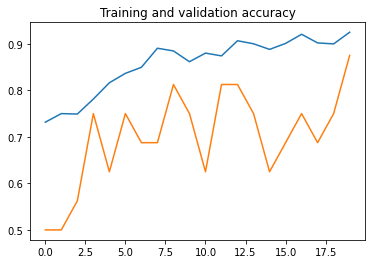

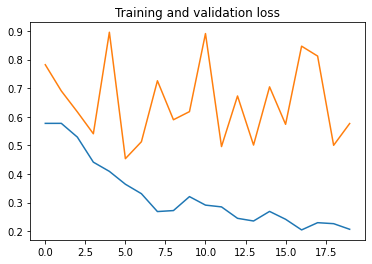

In [0]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_three.history['accuracy']
val_acc  = history_three.history['val_accuracy']
loss     = history_three.history['loss']
val_loss = history_three.history['val_loss']

epochs  = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,  loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

In [0]:
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_data = test_datagen.flow_from_directory(
    '/tmp/chest-xray-pneumonia/chest_xray/test/',
    class_mode='categorical',
    target_size = (150,150)
)

Found 624 images belonging to 2 classes.


.

.

TIME TO TEST OUR MODELS

model_2

In [0]:
results_2 = model_two.evaluate(test_data,batch_size=32,verbose=1)

20/20 [==============================] - 7s 339ms/step - loss: 0.3857 - accuracy: 0.9295


In [0]:
pred = model_two.predict(test_data,steps=624//32+1,verbose=1)

20/20 [==============================] - 7s 343ms/step


In [0]:
import numpy as np
predictions = np.argmax(pred,axis=1)

In [0]:
import seaborn as sns
import pandas as pd
def makeConMat(cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(pd.DataFrame(cm , index = ['Normal','Pneumonia'] , columns = ['Normal','Pneumonia']),cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',cbar=False)
    plt.show()

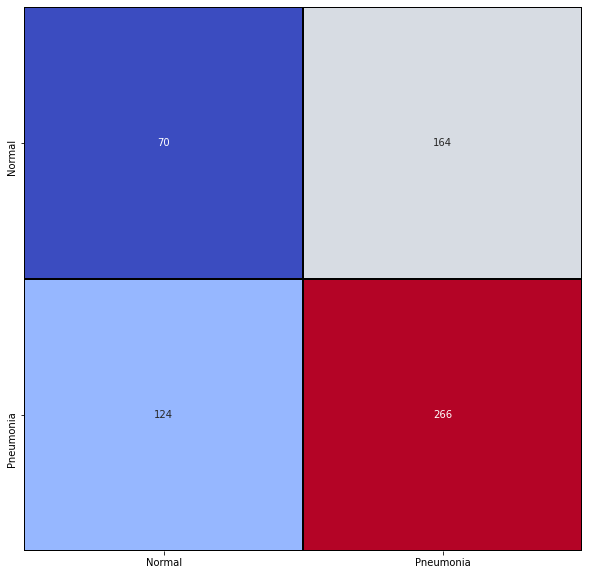

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_data.classes,predictions)
makeConMat(cm)

.

.

model

In [0]:
results_1 = model.evaluate(test_data,batch_size=32,verbose=1)

20/20 [==============================] - 7s 343ms/step - loss: 0.1875 - accuracy: 0.9359


In [0]:
pred_1  = model.predict(test_data,steps=624//32+1,verbose=1)

20/20 [==============================] - 7s 354ms/step


In [0]:
import numpy as np
predictions_1 = np.argmax(pred_1,axis=1)

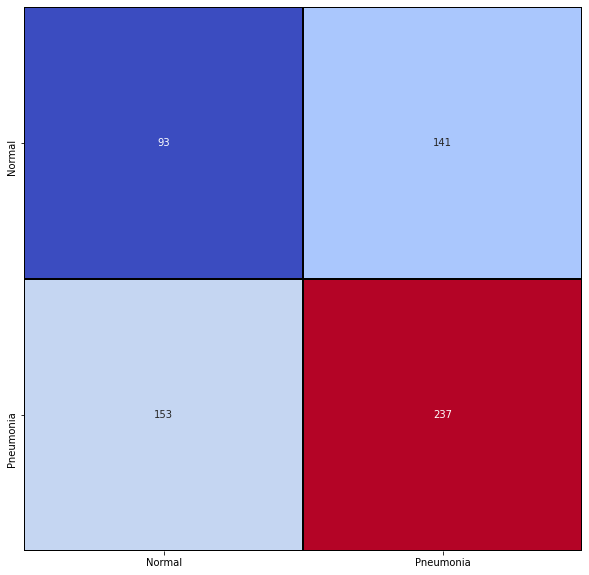

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_data.classes,predictions_1)
makeConMat(cm)

.

.

model_3

In [0]:
results_3 = model_three.evaluate(test_data,batch_size=32,verbose=1)

20/20 [==============================] - 9s 448ms/step - loss: 0.3033 - accuracy: 0.8958


In [0]:
pred_3  = model.predict(test_data,steps=624//32+1,verbose=1)

20/20 [==============================] - 7s 354ms/step


In [0]:
import numpy as np
predictions_3 = np.argmax(pred_3,axis=1)

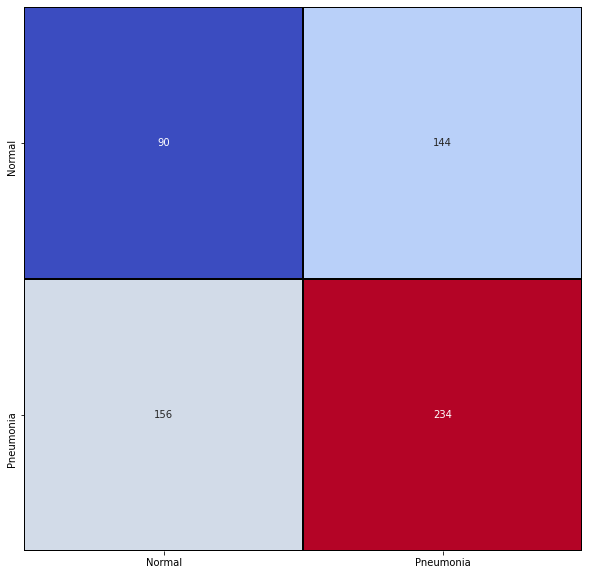

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_data.classes,predictions_3)
makeConMat(cm)

ALL I can say is we did a good job on a small dataset with all the three models.

You can try your own architecture and share the results. Would love to see what improvements you made.

Avoid Early stopping (my opinion)
Many people implement early stopping callback because of which the trainingis stopped when a particular accuracy is achieved. Which is not a good thing because the network is not well trained and many variety might be left in the data to explore which can effect the test data.
